In [1]:
import math
import numpy as np
from LabIFSC import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import display, Latex

In [2]:
#Funções e constantes que serão utilizadas

permeabilidadeAr = (4*math.pi)*1e-7

def get_dados(csv,factorx=1e-2,factory=1e-3,fundox=0,fundoy=0):
    '''Pega os dados de um arquivo csv, retorna um dicionario com x:y
    factorx e factory são valores que multiplicam x e y, para arrumar grandezas por exemplo
    fundox e fundoy subtraem de x e y, para tirar valores de fundo por exemplo
    '''
    with open(csv,'r') as file:
        xtype,ytype = file.readline().split(',')
        data = {}
        for linha in file.readlines():
            linha = linha.split(',')
            data[(float(linha[0])*factorx)-fundox] = (float(linha[1])*factory)-fundoy
        
    return data

def get_coefAngular(x,y):
    '''Retorna uma tupla, onde o primeiro elemento é o coeficiente angular dos dados e o segundo é o erro associado'''
    assert len(x) == len(y), "As duas listas devem ter o mesmo tamanho"
    N = len(x)
    
    xbar = sum(x)/N
    ybar = sum(y)/N
    
    x2 = 0
    rms = 0
    rms2 = 0
    rmsy = 0
    for i in range(N):
        x2 += (x[i])**2
        rms += (x[i]-xbar)
        rmsy += (x[i]-xbar)*y[i]
        rms2 += (x[i]-xbar)**2
    
    a = rmsy/rms2    
    b = ybar - a*xbar
    
    deltay = 0
    for i in range(N):
        deltay += (a*x[i] + b - y[i])**2
        
    deltay = math.sqrt(deltay/(N-2))
    
    deltaa = deltay/(math.sqrt(rms2))
    deltab = math.sqrt(x2/(N*rms2))*deltay
    
    return a, deltaa
        
    

def campoBobina(x,espiras,corrente,permeabilidade,raio):
    '''
    Recebe:
        x: distância do centro da bobina
        espiras: quantidade de espiras
        corrente: corrente que está passando na bobina
        permeabilidade: permeabilidade elétrica do meio em que o experimento é feito
        raio: raio da bobina
        
    Retorna:
        Campo Magnético
    '''
    
    return espiras * (permeabilidade * corrente * raio**2)/(2*(x**2 + raio**2))**(3/2)

def campoHall(tensao,coeficiente):
    '''
    Recebe:
        tensao: Tensão Hall medida com a sonda
        coeficiente: o valor obtido durante a calibração
        
    Retorna:
        Campo Magnético naquele ponto
    '''
    
    
    return tensao*coeficiente

def campoSolenoide(espiras,corrente,comprimento,permeabilidade):
    '''
    Recebe:
        espiras: quantidade de espiras
        corrente: corrente passando pelo solenoide
        comprimento: comprimento do solenoide
        permeabilidade: permeabilidade magnética do meio
        
    Retorna:
        Campo Magnético do solenoide
    '''
    
    return (permeabilidade*espiras*corrente)/comprimento

def campoFio(distancia,corrente,permeabilidade):
    '''Faz a seguinte equação:
    (permeabilidade*corrente)/(distancia*2*math.pi)
    '''
    
    return (permeabilidade*corrente)/(distancia*2*math.pi)

def campoHelmholtz(z,corrente,permissividade,raio):
    '''((permissividade*corrente*raio**2)/2)*(1/((z-raio/2)**2 + raio**2)**(3/2)+1/((z+raio/2)**2 + raio**2)**(3/2))'''
    return ((permissividade*corrente*raio**2)/2)*(1/((z-raio/2)**2 + raio**2)**(3/2)+1/((z+raio/2)**2 + raio**2)**(3/2))

def campoAnti_Helmholtz(z,corrente,permissividade,raio):
    '''((permissividade*corrente*raio**2)/2)*(1/((z-raio/2)**2 + raio**2)**(3/2)-1/((z+raio/2)**2 + raio**2)**(3/2))'''
    return ((permissividade*corrente*raio**2)/2)*(1/((z-raio/2)**2 + raio**2)**(3/2)-1/((z+raio/2)**2 + raio**2)**(3/2))

### Calibração da Sonda Hall

In [3]:
#Dados
comprimentoSolenoide = 149*1e-3 #erro de 5e-5
espirasSolenoide = 760

data = get_dados('Data/calibracao.csv',factorx = 1,factory=1)#arquivo
amperagem = np.array(list(data.keys()))
voltagem = np.array(list(data.values()))

O Coeficiente é 0.00372±0.00004 T/V


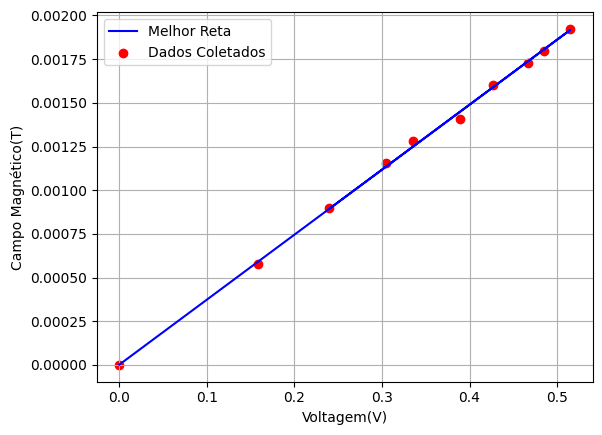

In [4]:
campoCalculado = [campoSolenoide(espirasSolenoide,i,comprimentoSolenoide,permeabilidadeAr) for i in amperagem]
    
param = np.polyfit(voltagem,campoCalculado,1)
#print(param)
    
coeficienteHall = param[0]
coef,erro = get_coefAngular(voltagem,campoCalculado)
print(f"O Coeficiente é {M((coeficienteHall,erro))}T/V")    
    
#plt.plot(voltagem,campoCalculado,label='Dados Coletados')
plt.plot(voltagem,[(param[0]*i + param[1]) for i in voltagem],label=f'Melhor Reta',color='blue')
plt.scatter(voltagem,campoCalculado,label='Dados Coletados',color='red')
plt.grid(True)
plt.xlabel('Voltagem(V)');plt.ylabel('Campo Magnético(T)')
plt.legend()
#plt.savefig('Results/calibracao.png')
plt.show()

### Medida do Campo Magnético na aproximação do fio infinito

- fio1.csv = 0.15 A
- fio2.csv = 1 A

In [210]:
#Dados
corrente = 1
#data = get_dados("Data/fio2.csv",factorx=1e-2,factory=-1e-3,fundox=0,fundoy=0.0025)
#data = get_dados("DataJ/fioP.csv",factorx=1e-2,factory=1e-3,fundox=0,fundoy=0)
data = get_dados("DataJ/fioJ.csv",factorx=1e-2,factory=1e-3,fundox=0.01,fundoy=0.0051)
dist = np.array(sorted(data))
tensao = np.array([data[i] for i in dist])

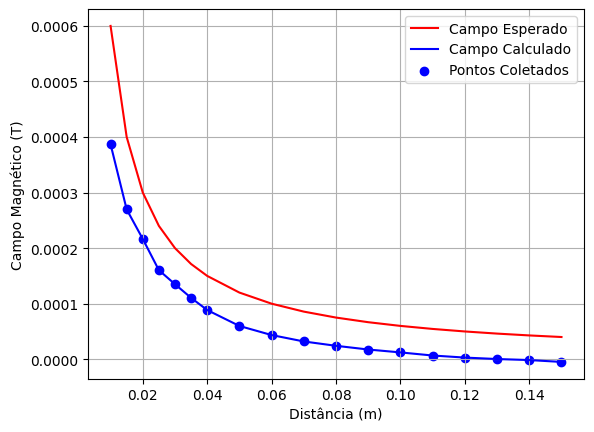

In [211]:
campoEsperado = np.array([campoFio(z,corrente,permeabilidadeAr) for z in dist])*30
campoCalculado = np.array([v*coeficienteHall for v in tensao])

#fittings
param,_ = curve_fit(campoFio,dist,campoCalculado,p0=[corrente,permeabilidadeAr])
def campoFioAlt(x,param):
    return campoFio(x,param[0],param[1])

#Plotagem
plt.plot(dist,campoEsperado,label="Campo Esperado",color='red')
plt.plot(dist,campoCalculado,label="Campo Calculado",color='blue')
plt.scatter(dist,campoCalculado,label="Pontos Coletados",color="blue")
#plt.plot(dist,np.array([campoFioAlt(x,param) for x in dist])*1e3,label="Teste")
plt.xlabel('Distância (m)');plt.ylabel('Campo Magnético (T)')
plt.grid(True)
plt.legend()
#plt.savefig('Results/campoFioJ.png')
plt.show()

In [110]:
print(param)

[6.11119555e+00 4.63452317e-06]


### Medida do Campo Magnético de uma Bobina

Primeiramente medir os parâmetros da bobina -> diâmetro, numero de espiras

Colocar a sonda hall no suporte e medir sem corrente -> medir tensão de fundo

Corrente em 1 A e medir com a sonda variando a distância da bobina -> fazer antes, dentro e depois da bobina

Inverter o sentido da corrente na bobina e ver o que acontece

Fazer um gráfico do campo medido com o campo esperado em função de x

In [247]:
#Dados
espiras = 130
corrente = 1
raio = 14.05*1e-2 #esse é o do João
#raio = (32.4e-2)/2 - 30.25e-3+10.9e-3
tensaoFundo = 0.004

data = get_dados('Data/bobina.csv',factorx=0.01,factory=0.001,fundox=0.145,fundoy=tensaoFundo)
#data = get_dados('DataJ/bobinaJ.csv',factorx=0.01,factory=0.001,fundox=0,fundoy=tensaoFundo)
dist = np.array(sorted(data))
tensao = np.array([data[i] for i in dist])

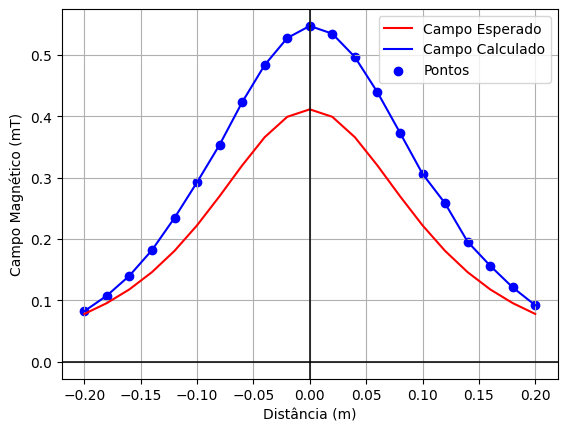

In [248]:
campoEsperado = np.array([campoBobina(z,espiras,corrente,permeabilidadeAr,raio) for z in dist])
campoCalculado = np.array([v*coeficienteHall for v in tensao])
    
plt.plot(dist,campoEsperado*1e3,label='Campo Esperado',color='red')
plt.plot(dist,campoCalculado*1e3,label="Campo Calculado",color='blue')
plt.scatter(dist,campoCalculado*1e3,label='Pontos',color='blue')
plt.grid(True)
plt.legend()
plt.xlabel('Distância (m)');plt.ylabel('Campo Magnético (mT)')
ax = plt.gca()
ax.axhline(0, color='black', linewidth=1.1)  # y = 0
ax.axvline(0, color='black', linewidth=1.1)  # x = 0
#plt.savefig('Results/campoBobinaJ.png')
plt.show()

def campoBobinaAlt(x,corrente,permeabilidade,raio):
    espiras = 130
    return espiras * (permeabilidade * corrente * raio**2)/(2*(x**2 + raio**2))**(3/2)

param1, _ = curve_fit(campoBobinaAlt,dist,campoCalculado,p0=[corrente,permeabilidadeAr,raio])
#param2, _ = curve_fit(campoBobinaAlt,dist,campoEsperado,p0=[corrente,permeabilidadeAr,raio]) #como esperado, deu tudo igual

In [49]:
print(param1)
print(corrente,permeabilidadeAr,raio)

[1.25121447e+00 1.36005549e-06 1.44385648e-01]
1 1.2566370614359173e-06 0.14265


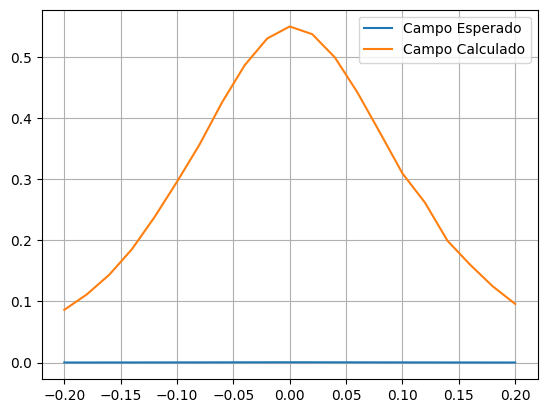

In [36]:
with open('DataJ/bobinaJ.csv','r') as file:
    xtype,ytype = file.readline().split(',')
    x,y = [],[]
    data = {}
    for linha in file.readlines():
        linha = linha.split(',')
        x.append(float(linha[0]))
        y.append(float(linha[1]))
        data[float(linha[0])*1e-2] = (float(linha[1])-4)*1e-3
    dataSorted = sorted(data)
    
campoEsperado = [campoBobina(z,espiras,corrente,permeabilidadeAr,raio) for z in dataSorted]
campoCalculado = []
for val in dataSorted:
    campoCalculado.append(data[val]*coeficienteHall)
    

plt.plot(dataSorted,campoEsperado,label='Campo Esperado')
plt.plot(dataSorted,campoCalculado,label="Campo Calculado")
plt.grid(True)
plt.legend()
plt.show()

### Campo Magnético de um par de Bobina (Helmholtz)

Medir as características das bobinas -> diâmetro, quantidade de espiras

Colocar uma na frente da outra e colocar a corrente igual nas duas (soma os campos magnéticos)

Corrente em 1 A, medir a tensão hall em pontos entre as bobinas e depois de cada uma das bobinas

Fazer um gráfico com o campo magnético medido e o calculado, em função da distância do centro das bobinas

In [8]:
#Dados
raio = 14.05*1e-2
corrente = 1
tensaoFundo = 0.004

data = get_dados('DataJ/helJ.csv',factorx=1e-2,factory=1e-3,fundoy=tensaoFundo)
dist = np.array(sorted(data))
tensao = np.array([data[i] for i in dist])

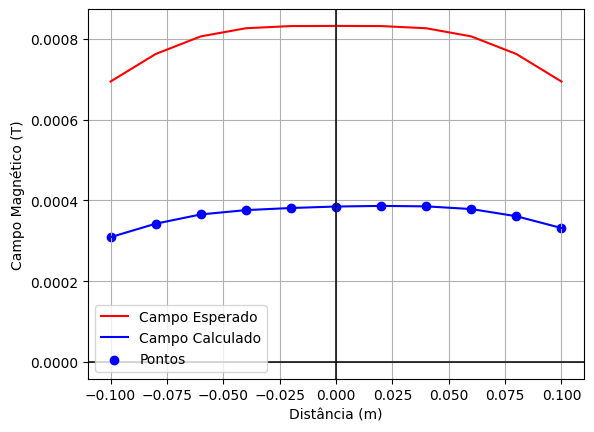

In [10]:
campoEsperado = np.array([campoHelmholtz(z,corrente,permeabilidadeAr,raio) for z in dist])*130
campoCalculado = np.array([v*0.0037 for v in tensao])

plt.plot(dist,campoEsperado,label='Campo Esperado',color='red')
plt.plot(dist,campoCalculado,label="Campo Calculado",color='blue')
plt.scatter(dist,campoCalculado,label='Pontos',color='blue')
plt.grid(True)
plt.legend()
plt.xlabel('Distância (m)');plt.ylabel('Campo Magnético (T)')
ax = plt.gca()
ax.axhline(0, color='black', linewidth=1.1)  # y = 0
ax.axvline(0, color='black', linewidth=1.1)  # x = 0
#plt.savefig('helJ.png')
plt.show()

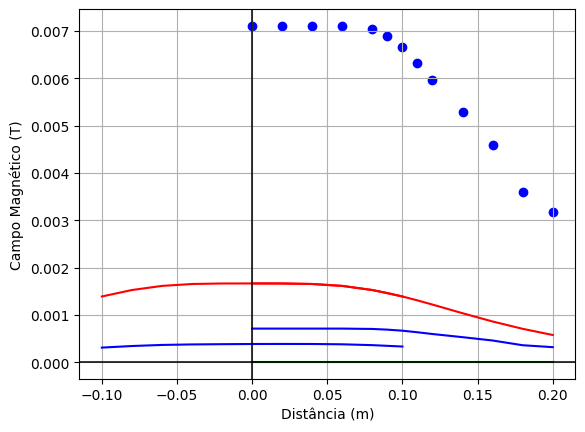

In [232]:
#Dados
raio = 14.05*1e-2
corrente = 1
tensaoFundo = 0.004

data1 = get_dados('DataJ/helP.csv',factorx=1e-2,factory=1e-3,fundoy=tensaoFundo)
dist1 = np.array(sorted(data1))
tensao1 = np.array([data1[i] for i in dist1])

data2 = get_dados('DataJ/helmholtzJ.csv',factorx=1e-2,factory=1e-3,fundoy=tensaoFundo)
dist2 = np.array(sorted(data2))
tensao2 = np.array([data2[i] for i in dist2])

campoEsperado1 = np.array([campoHelmholtz(z,corrente,permeabilidadeAr,raio) for z in dist1])*130*2
campoCalculado1 = np.array([v*0.0037 for v in tensao1])

campoEsperado2 = np.array([campoHelmholtz(z,corrente,permeabilidadeAr,raio) for z in dist2])*130*2
campoCalculado2 = np.array([v*0.0037 for v in tensao2])

plt.plot(dist1,campoEsperado1,label='Campo Esperado',color='red')
plt.plot(dist1,campoCalculado1,label="Campo Calculado",color='blue')
plt.plot(dist2,campoEsperado2,label='Campo Esperado',color='red')
plt.plot(dist2,campoCalculado2,label="Campo Calculado",color='blue')
plt.plot(dist1,[0.715*((permeabilidadeAr*corrente)/raio)]*len(dist1),color="green")
plt.scatter(dist,campoCalculado,label='Pontos',color='blue')
plt.grid(True)
#plt.legend()
plt.xlabel('Distância (m)');plt.ylabel('Campo Magnético (T)')
ax = plt.gca()
ax.axhline(0, color='black', linewidth=1.1)  # y = 0
ax.axvline(0, color='black', linewidth=1.1)  # x = 0
#plt.savefig('')
plt.show()

In [230]:
0.715*permeabilidadeAr*1/raio

6.3949857574852725e-06

### Campo Magnético de Bobina anti-Helmholtz

Repita os procedimentos do método de helmholtz, porém com a corrente de uma das bobinas trocadas

In [243]:
#Dados
raio = 14.05*1e-2
corrente = 1
tensaoFundo = 0.004

data = get_dados('Data/anti-hel.csv',factorx=1e-2,factory=-1e-3,fundox=0.199,fundoy=tensaoFundo)
dist = np.array(sorted(data))
tensao = np.array([data[i] for i in dist])

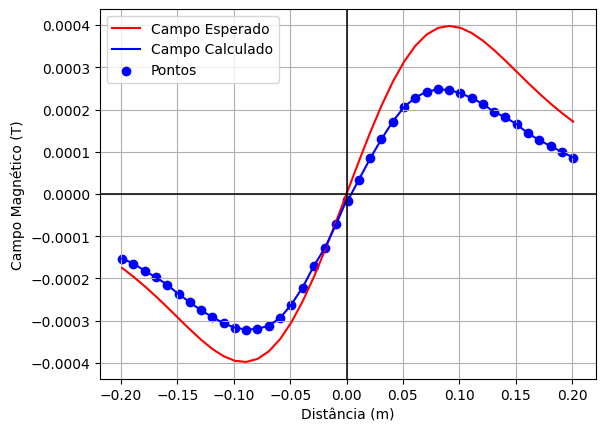

In [244]:
campoEsperado = np.array([campoAnti_Helmholtz(z,corrente,permeabilidadeAr,raio) for z in dist])*130
campoCalculado = np.array([v*coeficienteHall for v in tensao])

plt.plot(dist,campoEsperado,label='Campo Esperado',color='red')
plt.plot(dist,campoCalculado,label="Campo Calculado",color='blue')
plt.scatter(dist,campoCalculado,label='Pontos',color='blue')
plt.grid(True)
plt.legend()
plt.xlabel('Distância (m)');plt.ylabel('Campo Magnético (T)')
ax = plt.gca()
ax.axhline(0, color='black', linewidth=1.1)  # y = 0
ax.axvline(0, color='black', linewidth=1.1)  # x = 0
#plt.savefig('Results/anti-hel.png')
plt.show()

Percebemos que o sinal da tensão Hall depende do lado que tá virado o sensor

Medimos as posições na régua, depois precisa pegar o meio e ir fazendo a posição correta pra pornográfico

13.1 - 15.9 -> Pontos de uma bobina

### Anti-Helmanz
Meio -> 19.9 cm

Utilizando uma bussola, reparamos que, no meio, ela marca corretamente

colocar um erro de mais ou menos 1 cm na posição porque não sabemos onde exatamente a sonda mede

Tamanho da sonda -> +- 4.5 cm

In [ ]:
with open("Data/fio2.csv","r") as file:
    file.readline()
    file.readline()
    x,y = [],[]
    for linha in file.readlines():
        linha = linha.split(',')
        x.append(float(linha[0]))
        y.append(float(linha[1]))
        
x = np.array(x)*1e-2
y = np.array(y)

for dist in x:
    print("%.7f"%((1/dist) * 2*1e-7))

### Células que eu não pretendo usar mas tenho medo de apagar

In [ ]:
with open('Data/calibracao-segundodDia.csv','r') as file:
    xtype,ytype = file.readline().split(',')
    x,y = [],[]
    for linha in file.readlines():
        linha = linha.split(',')
        x.append(float(linha[0]))
        y.append(float(linha[1]))
        
campo = [campoSolenoide(espirasSolenoide,i,comprimentoSolenoide,permeabilidadeAr) for i in x]
    
param = np.polyfit(y,campo,1)
print(param)
    
plt.scatter(y,campo,label='Pontos')
plt.plot(y,campo,label='dados')
plt.plot(y,[(param[0]*i + param[1]) for i in y],label='aproximação')
plt.grid(True)
plt.xlabel(xtype);plt.ylabel(ytype)
plt.legend()
plt.show()

coeficienteHall = param[0]
print(param[0])


In [ ]:
corrente = 1

#dataJ = get_dados("DataJ/fioJ.csv")
data = get_dados("Data/fio2.csv")

#dataSortedJ = sorted(dataJ)
dataSorted = sorted(data)


"""campoEsperadoJ = [campoFio(corrente,permeabilidadeAr,z) for z in dataSortedJ]
campoCalculadoJ = [(dataJ[i]-(0.0051))*1.41e-4 for i in dataSortedJ]"""

campoEsperado = [campoFio(corrente,permeabilidadeAr,z) for z in dataSorted]
campoCalculado = [-(data[i]-(0.0051))*coeficienteHall for i in dataSorted]

"""plt.plot(dataSortedJ,campoEsperadoJ,label="Esperado João")
plt.plot(dataSortedJ,campoCalculadoJ,label="Calculado João")
#plt.plot(dataSorted,campoEsperado,label="Esperado Pedro")
#plt.plot(dataSorted,campoCalculado,label="Calculado Pedro")
plt.grid(True)
plt.legend()
plt.show()"""